In [1]:
import os

# Define paths
DATA_PROCESSED = "../data/processed/"
RESULTS_OUT = "../models/"

# Make sure directories exist
os.makedirs(DATA_PROCESSED, exist_ok=True)
os.makedirs(RESULTS_OUT, exist_ok=True)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load preprocessed data
X_train = pd.read_csv(os.path.join(DATA_PROCESSED, "X_train.csv"))
y_train = pd.read_csv(os.path.join(DATA_PROCESSED, "y_train.csv"))
X_test = pd.read_csv(os.path.join(DATA_PROCESSED, "X_test.csv"))
y_test = pd.read_csv(os.path.join(DATA_PROCESSED, "y_test.csv"))

# In case y files were saved as DataFrames with one column
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print("Data successfully loaded!")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Data successfully loaded!
X_train: (20620, 8), X_test: (7000, 8)
y_train: (20620,), y_test: (7000,)


In [4]:
# Load Preprocessed Data for XGBoost Training
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

# Initialize XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9
)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate on test data
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_proba)

print("Evaluation Results:")
print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"ROC-AUC:    {roc:.4f}")



Evaluation Results:
Accuracy:   0.9354
Precision:  0.8951
Recall:     0.9340
F1-score:   0.9142
ROC-AUC:    0.9857


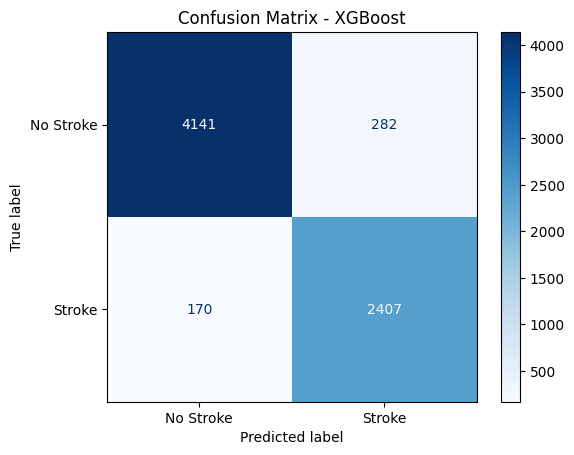

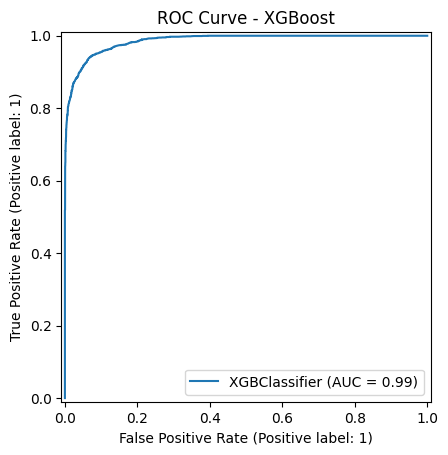

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Stroke', 'Stroke']).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("ROC Curve - XGBoost")
plt.show()


In [6]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

param_dist_improved = {
    'n_estimators': [400, 600, 800, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.01, 0.05],
    'reg_lambda': [1.0, 1.2],
    'scale_pos_weight': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_improved,
    n_iter=40,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nBest Parameters (Improved Search):")
print(random_search.best_params_)
print("Best Cross-Validated F1 Score:", random_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\sisur\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:59:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters (Improved Search):
{'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.7}
Best Cross-Validated F1 Score: 0.9333967726036525


In [7]:
# Evaluate Best Model from RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)

# Get the best estimator from RandomizedSearchCV
best_xgb_random = random_search.best_estimator_

# Predictions on test set
y_pred = best_xgb_random.predict(X_test)
y_proba = best_xgb_random.predict_proba(X_test)[:, 1]

# Calculate metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_proba)

# Print formatted results
print("\nTuned Model Performance (RandomizedSearchCV):")
print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"ROC-AUC:    {roc:.4f}")


Tuned Model Performance (RandomizedSearchCV):
Accuracy:   0.9361
Precision:  0.8971
Recall:     0.9336
F1-score:   0.9150
ROC-AUC:    0.9859


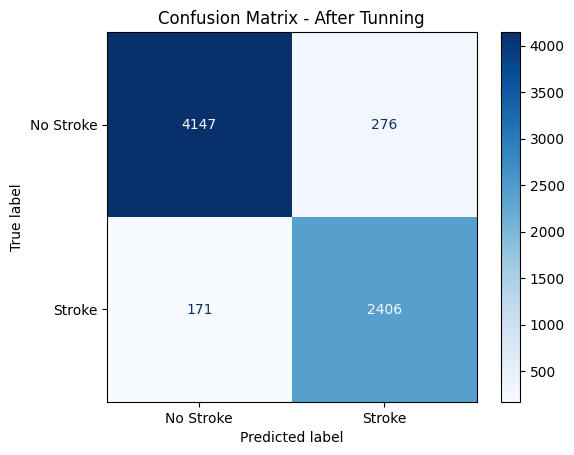

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Stroke', 'Stroke']).plot(cmap='Blues')
plt.title("Confusion Matrix - After Tunning")
plt.show()

In [9]:
# Save model for pipeline integration
import joblib
joblib.dump(best_xgb_random, os.path.join(RESULTS_OUT, "stroke_model.pkl"))
print("\n XGBoost model trained and saved successfully")


 XGBoost model trained and saved successfully!
